In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load data
train_df = pd.read_csv('E:/Vehicle/train_df.csv')
test_df = pd.read_csv('E:/Vehicle/test_df.csv')

In [3]:
# Handle truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create ImageDataGenerators
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

In [4]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 476 validated image filenames belonging to 5 classes.
Found 119 validated image filenames belonging to 5 classes.
Found 149 validated image filenames belonging to 5 classes.


In [5]:
# Load pre-trained VGG16 model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False


In [6]:
# Create the new model
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Train the model
history = model.fit(train_images, validation_data=val_images, epochs=30)


Epoch 1/30


C:\Users\anand\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 147s 7s/step - accuracy: 0.2397 - loss: 1.6212 - val_accuracy: 0.2857 - val_loss: 1.5833
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.2737 - loss: 1.5869 - val_accuracy: 0.2437 - val_loss: 1.5711
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.2763 - loss: 1.5612 - val_accuracy: 0.2857 - val_loss: 1.5187
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.3107 - loss: 1.5298 - val_accuracy: 0.3445 - val_loss: 1.4865
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.4167 - loss: 1.4797 - val_accuracy: 0.3109 - val_loss: 1.4815
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.3944 - loss: 1.4473 - val_accuracy: 0.4286 - val_loss: 1.4494
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.3903 - loss: 1.4626 - val_accuracy: 0.3613 - val_loss: 1.4860
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.3747 - loss: 1.4224 - val_accuracy: 0.3866 - val_loss: 1.41

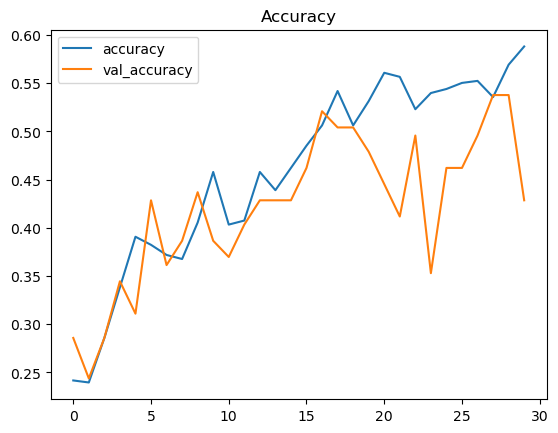

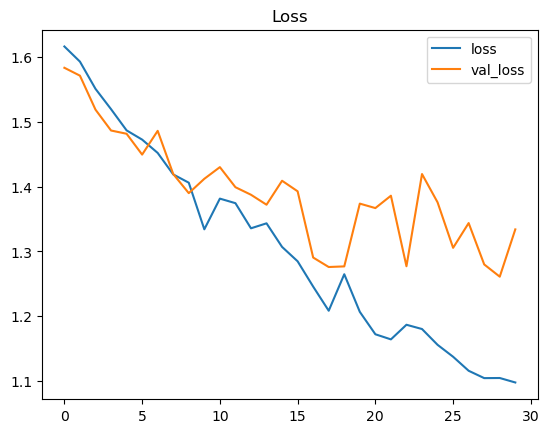

In [8]:
# Plot accuracy and loss
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [9]:
# Save model and history
model.save('E:/Vehicle/model/vgg16_model.h5')
pd.DataFrame(history.history).to_csv('E:/Vehicle/results/vgg16_model_history.csv')

# Evaluate model
results = model.evaluate(test_images, verbose=0)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1] * 100, "%")

C:\Users\anand\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 1.3868557214736938
Test Accuracy: 49.66442883014679 %
